## Building The Country Page Widgets

Charlie has added the following datasets to the **STAGING** API for the construction of the new country pages widgets. This notebook details how to query these datasets to create a the required widgets.


```
[
    {
        "name": "IFL 2000",
        "gain": "27ed6d3c-89e8-4087-aa78-1b6619c0e8d5",
        "loss": "cbf299f8-f365-4ba3-ad10-b8c1324bea62",
        "extent": "1676bb7f-a858-4298-8faa-c85cb169ca20"
    },

    {
        "name": "IFL 2013",
        "gain": "19be9cf6-3dfc-4b77-b95e-39a6751e55bf",
        "loss": "2a4bf55c-7e0e-45cd-ac3f-f1e890c0bd22",
        "extent": "2cfc35b0-aa9b-4939-8265-ee643b3afeb5"
    },

    {
        "name": "wdpa",
        "gain": "23519a73-f4b8-4bb6-8a6a-1d84c38debca",
        "loss": "9289fdf7-b2b0-4cbf-8951-9dd4dcd8ccd7",
        "extent": "8d7e23ec-bc8c-4434-bc6a-6ce40459b424"
    },

    {
        "name": "primary forests",
        "gain": "fd3b3a12-121e-4189-96a3-d8c26b70952d",
        "loss": "7a5b92ab-2d35-45f3-b923-20c9a46d4873",
        "extent": "b987b360-190e-4560-a632-03946347d226"
    },

    {
        "name": "biodiversity hot spots",
        "gain": "bd061864-8efb-41a7-8ba0-6f4d25ed1fd8",
        "loss": "32a963c1-26d7-4a21-b602-17144fd78c0f",
        "extent": "6c00c104-a75b-4b0b-9c33-0d0aa29cdf93"
    },

    {
        "name": "gadm28 only",
        "gain": "e78a9c36-ed15-467a-babd-0a5ac21d07d7",
        "loss": "88994c38-1ea1-4a32-82ca-073547d11176",
        "extent": "f0e01525-9576-4613-a74b-3290c94047ca"
    },

    {
        "name": "GFW Plantations",
        "gain": "94a883de-4eb4-4be8-a05f-c77ea8d9c6a3",
        "loss": "17a7970a-23ba-45ab-8004-37090b4e2502",
        "extent": "9b617bbb-b99b-4543-832d-665adeec3341"
    },

    {
        "name": "GFW Managed Forests",
        "gain": "c88957d7-4635-4fb7-b729-db565122529d",
        "loss": "c500cb21-fdf0-426b-9a89-4a581f33ed18",
        "extent": "f9e40f0f-4f9f-4d93-957d-1fa15dd29333"
    }
]
```

In [28]:
import requests
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
# Example of what is in the data tables and how to simply read them:
ds = "f0e01525-9576-4613-a74b-3290c94047ca" # gadm28 tree cover extent UMD 2013
url = "https://staging-api.globalforestwatch.org/query"
sql = (f"SELECT * FROM {ds} WHERE iso = 'BRA' AND thresh=30 LIMIT 2")
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
r.json()

https://staging-api.globalforestwatch.org/query?sql=SELECT+%2A+FROM+f0e01525-9576-4613-a74b-3290c94047ca+WHERE+iso+%3D+%27BRA%27+AND+thresh%3D30+LIMIT+2
Status: 200


{'data': [{'_id': 'AV5SxVwVD0oexj_vqcdH',
   'adm1': 1,
   'adm2': 11,
   'area': 806167.3365414925,
   'iso': 'BRA',
   'thresh': 30},
  {'_id': 'AV5SxVwVD0oexj_vqcdP',
   'adm1': 1,
   'adm2': 3,
   'area': 1786.439707780866,
   'iso': 'BRA',
   'thresh': 30}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
     'datasetUrl': '/v1/query/f0e01525-9576-4613-a74b-3290c94047ca'}},
   'http_method': 'POST',
   'url': '/v1/dataset/f0e01525-9576-4613-a74b-3290c94047ca/clone'}}}

# Tree cover widget

Default view where plantations data aviable for a country:

Uses:
    * Tree cover 2013 ("extent": "2cfc35b0-aa9b-4939-8265-ee643b3afeb5")
    * Plantations ("extent": "9b617bbb-b99b-4543-832d-665adeec3341")
    * Area of country

To calculate 3 slices in a pie chart:
    * Tree plantations
    * Natural forest (tree cover 2013 - tree plantations)
    * Non-forest (total area - tree cover 2013)



In [115]:
# note adm0 = BRA, adm1 = 4  is Amazonas
# adm0 = BRA, adm1 = 4, adm2 = 141 is Amaturá  (many forests)
# adm0 = BRA, adm1 = 12, adm2 = 1434 is Mato Grosso, Cáceres
# adm0 = BRA, adm1 = 14, adm2 = 2404 is Para, Altamira 
# adm0 = BRA, adm1 = 16, adm2 = 3135 - largest area of plantations (Turning this on seems to reveal a bug)

url = "https://staging-api.globalforestwatch.org/query"
adm0 = 'BRA'
threshold = 30
adm1 = 4
adm2 = None

In [116]:
def extent_queries(ds, adm0, adm1=None, adm2 = None):
    if adm0 and not adm1 and not adm2:
        print('Request for adm0 area')
        sql = (f"SELECT SUM(area) as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND thresh = {threshold}")
    elif adm0 and adm1 and not adm2:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM(area) as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} AND thresh = {threshold}")
    elif adm0 and adm1 and adm2:
        print('Request for  adm2 area')
        sql = (f"SELECT area as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} AND adm2 = {adm2} AND thresh = {threshold}") 
    return sql

In [117]:
##  UMD Tree cover extent 2013 over gadm28 areas 
ds = "f0e01525-9576-4613-a74b-3290c94047ca"
sql = extent_queries(ds=ds, adm0=adm0, adm1=adm1, adm2=adm2)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2013 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2013 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2013} ha")

Request for  adm1 area
https://staging-api.globalforestwatch.org/query?sql=SELECT+SUM%28area%29+as+value+FROM+f0e01525-9576-4613-a74b-3290c94047ca+WHERE+iso+%3D+%27BRA%27+AND+adm1+%3D+4+AND+thresh+%3D+30
Status: 200
{'data': [{'value': 129758884.22265625}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/f0e01525-9576-4613-a74b-3290c94047ca'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/f0e01525-9576-4613-a74b-3290c94047ca/clone'}}}

BRA 4 None Gadm28 Tree cover extent = 129758884.22265625 ha


So far I don't like this value. It is way too low: the 2000 UMD extent data for Brazil gives 519,187,505 ha
From this table we are getting 244,872,188 ha. Doesn't look right...

In [118]:
# GFW plantations (should be area of forest intersecting tree plantations at admin2 level from gadm28 shapes)

ds = "9b617bbb-b99b-4543-832d-665adeec3341"
sql = extent_queries(ds=ds, adm0=adm0, adm1=adm1, adm2=adm2)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    plantations = r.json().get('data')[0].get('value')
except:
    plantations = 0.0
print(f"\n{adm0} {adm1} {adm2} plantation area = {plantations} ha")

Request for  adm1 area
https://staging-api.globalforestwatch.org/query?sql=SELECT+SUM%28area%29+as+value+FROM+9b617bbb-b99b-4543-832d-665adeec3341+WHERE+iso+%3D+%27BRA%27+AND+adm1+%3D+4+AND+thresh+%3D+30
Status: 200
{'data': [{'value': 4542.618835449219}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/9b617bbb-b99b-4543-832d-665adeec3341'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/9b617bbb-b99b-4543-832d-665adeec3341/clone'}}}

BRA 4 None plantation area = 4542.618835449219 ha


In [126]:
def area_queries(adm0, adm1=None, adm2 = None):
    """If an admin0 or admin 1 area is requestd, use precalulated tables.
       If an admin2 is requested, calculate the area from the geometry.
    """
    if adm0 and not adm1 and not adm2:
        print('Request for adm0 area')
        sql = ("SELECT land as value "
                "FROM umd_nat_staging "
               f"WHERE iso = '{adm0}' "
                " AND year = 2001 "
                " and thresh = 30 ")
    elif adm0 and adm1 and not adm2:
        print('Request for adm1 area')
        sql = ("SELECT land as value "
                "FROM umd_subnat_staging "
               f"WHERE iso = '{adm0}' "
               f" AND id1 = {adm1} "
                " AND year = 2001 "
                " and thresh = 30 ")
    elif adm0 and adm1 and adm2:
        print('Request for adm2 area')
        sql = ("SELECT ROUND(ST_AREA(the_geom::geography) * 0.0001) as value "
                "FROM gadm28_adm2 "
                f"WHERE iso = '{adm0}' "
                f"AND id_1 = {adm1} "
                f"AND id_2 = {adm2} ")
    return sql

In [127]:
# Total area (ha) of selected area based on gadm28 table in Carto account

sql = area_queries(adm0=adm0, adm1=adm1, adm2=adm2)

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

total_area = r.json().get('rows')[0].get('value')
print(f"\n {total_area} ha total area selected")

Request for adm1 area
https://wri-01.carto.com/api/v2/sql?q=SELECT+land+as+value+FROM+umd_subnat_staging+WHERE+iso+%3D+%27BRA%27++AND+id1+%3D+4++AND+year+%3D+2001++and+thresh+%3D+30+ 

{'fields': {'value': {'type': 'number'}},
 'rows': [{'value': 157327057.085}],
 'time': 0.088,
 'total_rows': 1}

 157327057.085 ha total area selected


In [128]:
print(f"plantations={plantations:g}, tree cover={tree_cover_extent_2013:g}, area={total_area:g}")
plantations, tree_cover_extent_2013 - plantations, total_area - tree_cover_extent_2013

plantations=4542.62, tree cover=1.29759e+08, area=1.57327e+08


(4542.618835449219, 129754341.6038208, 27568172.86234376)

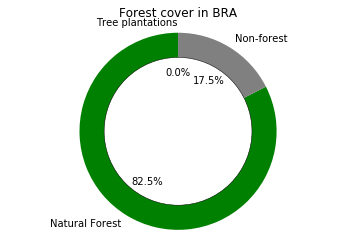

In [129]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Tree plantations', 'Natural Forest', 'Non-forest'
sizes = [plantations, tree_cover_extent_2013 - plantations, total_area - tree_cover_extent_2013]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['orange','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title(f'Forest cover in {adm0}')
plt.show()

#### Problems

** Areas **: As we calculate areas in this case dynamically from geometries, we will get inconsisntent results with the rest of the site. 
To resolve this, we need the areas pre-calculated in a table using the same method that they have previously been calculated from. I.e. it needs to match the same method of the `https://wri-01.carto.com/tables/umd_subnat_staging` table (which currently is at admin1 level.

* Possible Solution: Charlie could produce an areas table, that has the area of the gadm28 geometries.

** Tree Cover **: current extent area is incorrect. For Brazil, nationally, the values are off by around a factor of 2. Perhaps I have the wrong table, but I can't see another possible table that should be used in this case.

** Plantations **: Again, plantation areas look dubious.

## FAO FOREST Widget

An FAO-based forest widget can be calcuated based on data in a carto table `https://wri-01.carto.com/tables/gfw2_countries`

It will take a little work, as the data stored in the carto table is % of primary, regenerated and planted forest. Therefore we must 1) get an area (ha) extent of the forest, 2) obtain the % values of various FAO forest statistics from the carto table, 3) derrive the real (ha) area of FAO forest for each category, and 4) get a value of absolute area of the country and subtract the values caluclated in step 3 from the total area to get non-forest. 

** Pie categories **

* Primary Forest
* Naturally Regenerated Forest
* Planted Forest
* Non-forest

**Notes** 

1. These data (and therefore this widget) is only avaiable at the NATIONAL (ADMIN 0) level. And should dissapear from the pages if any other area is selected.

1. These data have no threshold selection.

1. As these data are only national, we can simply rely on the `umd_nat_staging` table to provide areas directly, rather than needing to dynamically calculate the areas.

In [ ]:
# Variables
adm0 = 'BRA'

In [169]:
# First, get the FAO data from a carto table

sql = ("SELECT fao.iso, fao.name,forest_planted, forest_primary, "
         "forest_regenerated, fao.forest_primary, fao.extent, a.land as area_ha "
         "FROM gfw2_countries as fao "
         "INNER JOIN umd_nat_staging as a "
         "ON fao.iso=a.iso "
         "WHERE fao.forest_primary is not null "
         f"AND fao.iso = '{adm0}' "
         "AND a.year = 2001 "
         "AND a.thresh = 30 "
        )

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

fao_percent = r.json().get('rows')[0]

https://wri-01.carto.com/api/v2/sql?q=SELECT+fao.iso%2C+fao.name%2Cforest_planted%2C+forest_primary%2C+forest_regenerated%2C+fao.forest_primary%2C+fao.extent%2C+a.land+as+area_ha+FROM+gfw2_countries+as+fao+INNER+JOIN+umd_nat_staging+as+a+ON+fao.iso%3Da.iso+WHERE+fao.forest_primary+is+not+null+AND+fao.iso+%3D+%27BRA%27+AND+a.year+%3D+2001+AND+a.thresh+%3D+30+ 

{'fields': {'area_ha': {'type': 'number'},
            'extent': {'type': 'number'},
            'forest_planted': {'type': 'number'},
            'forest_primary': {'type': 'number'},
            'forest_regenerated': {'type': 'number'},
            'iso': {'type': 'string'},
            'name': {'type': 'string'}},
 'rows': [{'area_ha': 853281125.672,
           'extent': 492968489,
           'forest_planted': 2,
           'forest_primary': 41,
           'forest_regenerated': 57,
           'iso': 'BRA',
           'name': 'Brazil'}],
 'time': 0.007,
 'total_rows': 1}


In [171]:
# How to calculate the statitics needed based on the CARTO responses

naturally_regenerated =  fao_percent['extent']/ 100 *  fao_percent['forest_regenerated']
primary_forest = fao_percent['extent']/100 *  fao_percent['forest_primary']
planted_forest = fao_percent['extent']/100 * fao_percent['forest_planted']
non_forest = fao_percent['area_ha'] - (naturally_regenerated + primary_forest + planted_forest)

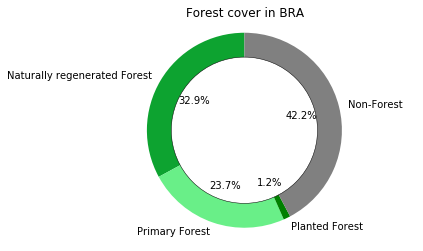

In [172]:
# FAO donut chart 
# NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
labels = ['Naturally regenerated Forest', 'Primary Forest', 'Planted Forest', 'Non-Forest']
sizes = [naturally_regenerated, primary_forest, planted_forest, non_forest]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title(f'Forest cover in {adm0}')
plt.show()

In [177]:
## RANK ALL COUNTRIES RELATIVE AMOUNT OF PRIMARY FOREST in 2015 and report that value for a dynamic sentence

sql = ("WITH mytable AS (SELECT fao.iso, fao.name, fao.forest_primary, fao.extent forest_extent, a.land as area_ha "
"FROM gfw2_countries as fao "
"INNER JOIN umd_nat_staging as a "
"ON fao.iso=a.iso "
"WHERE fao.forest_primary > 0 "
"AND a.year = 2001 "
"AND a.thresh = 30), "
"rank AS ( "
"SELECT forest_extent * (forest_primary/100)/area_ha * 100 as percent_primary ,iso "
"from mytable "
"ORDER BY percent_primary DESC), "
f"item as (select percent_primary from rank where iso = '{adm0}') "
"select count(*) as rank "
"from rank "
"WHERE percent_primary > (select percent_primary from item) ")

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

rank = r.json().get('rows')[0].get('rank')
print(rank)

https://wri-01.carto.com/api/v2/sql?q=WITH+mytable+AS+%28SELECT+fao.iso%2C+fao.name%2C+fao.forest_primary%2C+fao.extent+forest_extent%2C+a.land+as+area_ha+FROM+gfw2_countries+as+fao+INNER+JOIN+umd_nat_staging+as+a+ON+fao.iso%3Da.iso+WHERE+fao.forest_primary+%3E+0+AND+a.year+%3D+2001+AND+a.thresh+%3D+30%29%2C+rank+AS+%28+SELECT+forest_extent+%2A+%28forest_primary%2F100%29%2Farea_ha+%2A+100+as+percent_primary+%2Ciso+from+mytable+ORDER+BY+percent_primary+DESC%29%2C+item+as+%28select+percent_primary+from+rank+where+iso+%3D+%27BRA%27%29+select+count%28%2A%29+as+rank+from+rank+WHERE+percent_primary+%3E+%28select+percent_primary+from+item%29+ 

{'fields': {'rank': {'type': 'number'}},
 'rows': [{'rank': 27}],
 'time': 0.038,
 'total_rows': 1}
27


In [189]:
# Dyanmic sentence for FAO plot

print(f"FAO data from 2015 shows that {adm0} is ")

if  non_forest/area_ha > 0.5:
    print('mostly non-forest. ')
else:
    print('mostly forest. ')

if primary_forest > 0:
    print(f'Primary forest occupies {primary_forest/area_ha*100:3.1f}% of the country.')
    print(f"This gives {adm0} a rank of {rank}th out of 110 countries in terms of its relative amount of primary forest.")

FAO data from 2015 shows that BRA is 
mostly forest. 
Primary forest occupies 23.7% of the country.
This gives BRA a rank of 27th out of 110 countries in terms of its relative amount of primary forest.
